In [2]:
import projetLib as proj
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Subset
import torchvision
from tqdm import tqdm
import sys

In [3]:
size = (224,224)
dataset = proj.data.allImageDataset(size) # ,["msdos"]
dataloader = DataLoader(dataset, num_workers=2, batch_size=16, shuffle=True)

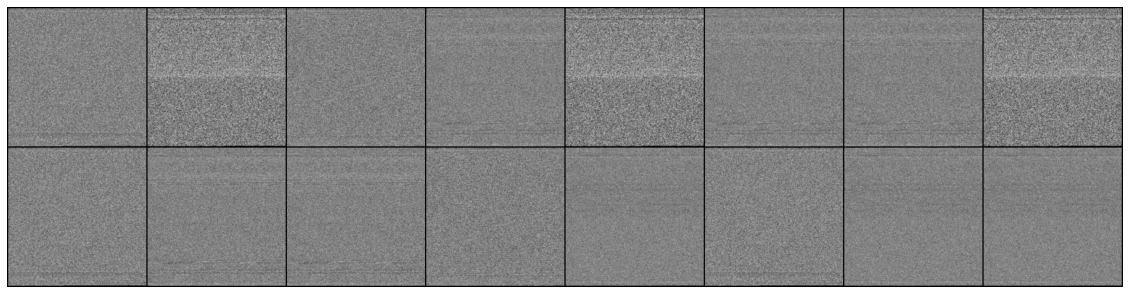

In [3]:
x,y  = next(iter(dataloader)) # On itére en général sur un dataloader avec une boucle pour récupérer des batch (de taille batch_size) mais on peut aussi récupérer seulement le premier batch comme ici
proj.utils.plot_img(x) # Affichage du premier batch

In [5]:
crossvalidN = 6
idfold = epoch % crossvalidN

test_proportion = 0.2
batch_size = 4
seed = 1
g = torch.Generator()
if seed != 0 :
    g.manual_seed(seed)

dataset = proj.data.allImageDataset(size) # ,["msdos"]
lenTrainTest = int(len(dataset)*(1-test_proportion))
restDataset  = lenTrainTest%batch_size
trainDataset,testDataset = torch.utils.data.random_split(dataset, [lenTrainTest-restDataset, len(dataset)-lenTrainTest+restDataset],g)
print(len(trainDataset),len(testDataset))

model = proj.model.GrayscaleResNet(torchvision.models.resnet.Bottleneck,[3, 4, 6, 3])

12 6


In [26]:
print(testDataset.dataset)

In [6]:
def get_accuracy(y_true, y_prob):
    accuracy = metrics.accuracy_score(y_true, y_prob > 0.5)
    return accuracy

In [23]:
import pandas as pd
import torch.nn as nn
import numpy as np
from torchmetrics import ConfusionMatrix

testloader = DataLoader(testDataset, num_workers=2, batch_size=batch_size, shuffle=True)

with torch.no_grad():
    
    model.eval()
    matrix = torch.zeros((2,2))
    confmat = ConfusionMatrix(task="binary", num_classes=2)
    for x, y in testloader : 
        outputs = model(x)
        outputs = torch.reshape(outputs,(len(y),))
        m = nn.Sigmoid()
        outputs = m(outputs)
        matrix  += confmat(outputs, y)

    (tp,fp),(fn,tn) = matrix
    accuracy = (tp+tn)/(tp+tn+fp+fn) 
    print(accuracy)
        
        #recall = tp/(tp+fn) # quelle proporition positif a été id correctement 
        #precision = tp/(tp+fp) # quelle proportion positif = correct


tensor([[0., 0.],
        [0., 0.]])
tensor([[0., 4.],
        [0., 0.]])
tensor(0.)
